In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from scipy.stats import lognorm
import scipy.stats as stats
from scipy.stats import norm
from scipy.optimize import minimize

from sklearn.model_selection import train_test_split    # untuk membaagi dataset menjadi model training dan datatest
from sklearn.preprocessing import StandardScaler        # untuk mengubah skala menjadi mean 0 dan deviasi standar 1
from sklearn.naive_bayes import BernoulliNB             # metode naive bayes untuk data biner
from sklearn.metrics import accuracy_score              # untuk mengukur tingkat akurasi dari model klasifikasi
from sklearn.naive_bayes import GaussianNB              # metode naive bayes untuk mengasumsikan data terdistribusi normal
from sklearn.metrics import confusion_matrix            # untuk memahami sejauh mana model klasifikasi memprediksi kelas dg benar
from sklearn.metrics import classification_report       

In [2]:
data = pd.read_csv("f:/Data D/TUGAS TH.4/TGA/ATAP/CSV/Rekap data/DATA KEAMANAN TUNGGAL")
data

,Panjang,Beban Tephra,Sudut,Aman Terhadap Penampang
0,6000,0.0,15,Aman
1,6000,0.0,20,Aman
2,6000,0.0,25,Aman
3,6000,0.0,30,Aman
4,6000,0.0,35,Aman
...,...,...,...,...
303,7500,1.0,25,Tidak Aman
304,7500,1.0,30,Tidak Aman
305,7500,1.0,35,Tidak Aman
306,7500,1.0,40,Tidak Aman


In [3]:
#Split data menjadi input dan output
X = data.iloc[:, [0, 1, 2]].values      # input
y = data.iloc[:, 3 ].values             # output

In [4]:
#Training dan test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42) 

#test_size=0.1 artinya 10% dari data dijadiin data buat test, 90% lain untuk training model

In [5]:
#Scaling data
sc = StandardScaler() 
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [6]:
#Training model dengan Gaussian Naive Bayes Classifier
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [7]:
#Test model
y_pred = classifier.predict(X_test)

print(accuracy_score(y_test, y_pred))
# rumus : TP + TN / (TP + TN + FP + FN)

0.9354838709677419


In [8]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
cm

# 14 : Jumlah data 'aman' yang diprediksi dengan benar oleh model
# 15 : Jumlah data 'tidak aman' yang diprediksi dengan benar oleh model
# 1   : Jumlah data 'aman' yang salah diprediksi sebagai 'tidak aman' oleh model
# 1 : Jumlah data 'tidak aman' yang salah diprediksi sebagai 'aman' oleh model

array([[14,  1],
       [ 1, 15]], dtype=int64)

In [9]:
print(classifier.predict(sc.transform([[6000, 1.5, 45]])))

['Tidak Aman']


In [10]:
#Prediksid data baru

tephra = []
Sudut = []
Panjang = []
CFSR = []

for panjang in range (6000, 7501, 100):
    for beban_tephra in range (1, 51, 1):
        beban_tephra = beban_tephra/50    
        for sudut in range (15, 46, 1):

            tephra.append(beban_tephra)
            Sudut.append(sudut)
            Panjang.append(panjang)
            CFSR.append(classifier.predict(sc.transform([[panjang, beban_tephra, sudut]])))

data ={
    'Panjang' : Panjang,
    'Beban Tephra': tephra,
    'Sudut' : Sudut,
    'Aman Terhadap Penampang' : CFSR
} 

data = pd.DataFrame(data)
print(data)

       Panjang  Beban Tephra  Sudut Aman Terhadap Penampang
0         6000          0.02     15                  [Aman]
1         6000          0.02     16                  [Aman]
2         6000          0.02     17                  [Aman]
3         6000          0.02     18                  [Aman]
4         6000          0.02     19                  [Aman]
...        ...           ...    ...                     ...
24795     7500          1.00     41            [Tidak Aman]
24796     7500          1.00     42            [Tidak Aman]
24797     7500          1.00     43            [Tidak Aman]
24798     7500          1.00     44            [Tidak Aman]
24799     7500          1.00     45            [Tidak Aman]

[24800 rows x 4 columns]


In [11]:
data.to_csv('f:/Data D/TUGAS TH.4/TGA/ATAP/DATA ML/DATA HASIL NAIVE BAYES.csv')
print(data)

       Panjang  Beban Tephra  Sudut Aman Terhadap Penampang
0         6000          0.02     15                  [Aman]
1         6000          0.02     16                  [Aman]
2         6000          0.02     17                  [Aman]
3         6000          0.02     18                  [Aman]
4         6000          0.02     19                  [Aman]
...        ...           ...    ...                     ...
24795     7500          1.00     41            [Tidak Aman]
24796     7500          1.00     42            [Tidak Aman]
24797     7500          1.00     43            [Tidak Aman]
24798     7500          1.00     44            [Tidak Aman]
24799     7500          1.00     45            [Tidak Aman]

[24800 rows x 4 columns]


In [12]:
# Function to perform optimization and plotting for each damage state
def plot_fragility_curve(IM, damaged_roof, total_roof, label, color):
    y=damaged_roof/total_roof
    # Define the neg-loglik function
    def neg_loglik(theta):
        mu = theta[0]
        sigma = theta[1]
        prob = norm.cdf((np.log(IM) - mu) / sigma)
        ll = y * np.log(prob) + (1 - y) * np.log(1 - prob)
        return -np.sum(ll)

    # Perform optimization to estimate the parameters
    theta_start = np.array([0, 1])
    res = minimize(neg_loglik, theta_start, method='Nelder-Mead') #meminimalkan fungsi likelihood

    mu_hat, sigma_hat = res.x #Ambil parameter yang dioptimalkan
    
    # Generate IM values for fragility curve
    IM_range = np.linspace(0, 1.0, 1000)

    # Calculate fragility curve
    p_collapse_range = norm.cdf((np.log(IM_range) - mu_hat) / sigma_hat)

    data ={
    'Beban Tephra' : IM_range,
    'Probability': p_collapse_range,
    }

    data= pd.DataFrame(data)
    print(data)
   
    csvdata = pd.DataFrame(data)
    csvdata.to_csv("f:/Data D/TUGAS TH.4/TGA/ATAP/DATA ML/EXCEL KURVA KERENTANAN NAIVE BAYES MLE.csv", index=False)

    # Plotting the fragility curve
    plt.plot(IM_range, p_collapse_range, label=f'{label} (mu={mu_hat:.2f}, sigma={sigma_hat:.2f})', color=color)

    plt.title('Lognormal CDF Vulnerability Curves using MLE')
    plt.xlabel('Tephra (kPa)')
    plt.ylabel('P[Collapse]')
    plt.legend()
    plt.grid(True)
    plt.savefig('f:/Data D/TUGAS TH.4/TGA/ATAP/DATA ML/KURVA KERENTANAN NAIVE BAYES MENGGUNAKAN MLE.png')

    return p_collapse_range, mu_hat, sigma_hat
    

In [13]:
Tephra = data['Beban Tephra'].unique()

print("Beban Tephra:", Tephra)

Beban Tephra: [0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56
 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84
 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


In [14]:
total_roof = data['Beban Tephra'].value_counts().sort_values().values
print(total_roof)

[496 496 496 496 496 496 496 496 496 496 496 496 496 496 496 496 496 496
 496 496 496 496 496 496 496 496 496 496 496 496 496 496 496 496 496 496
 496 496 496 496 496 496 496 496 496 496 496 496 496 496]


In [15]:
damaged_roof = []
for beban in Tephra:
    # Filter the DataFrame for the current speed
    filtered_data = data[data['Beban Tephra'] == beban]
    
    # Check if the current speed appears more than once
    count_tidak_aman = (filtered_data['Aman Terhadap Penampang'] == 'Tidak Aman').sum()

    damaged_roof.append(count_tidak_aman)  

data ={
'Beban Tephra' : Tephra,
'Damaged Roof': damaged_roof,
}

data= pd.DataFrame(data)
print(data)

csvdata = pd.DataFrame(data)
csvdata.to_csv("f:/Data D/TUGAS TH.4/TGA/ATAP/DATA ML/Damaged Roof NAIVE BAYES MLE", index=False)

    Beban Tephra  Damaged Roof
0           0.02             0
1           0.04             0
2           0.06             0
3           0.08             0
4           0.10             0
5           0.12             0
6           0.14             0
7           0.16             0
8           0.18             0
9           0.20             0
10          0.22             0
11          0.24             0
12          0.26             0
13          0.28             0
14          0.30             0
15          0.32             0
16          0.34             0
17          0.36             0
18          0.38             0
19          0.40             0
20          0.42             3
21          0.44            52
22          0.46           154
23          0.48           311
24          0.50           423
25          0.52           484
26          0.54           496
27          0.56           496
28          0.58           496
29          0.60           496
30          0.62           496
31      

In [16]:
# Given data for each damage state
IM_DS1 = np.array(Tephra)
damaged_roof = np.array(damaged_roof)
total_roof = np.array(total_roof)

In [17]:
print (IM_DS1)

[0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26 0.28
 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56
 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82 0.84
 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


     Beban Tephra  Probability
0        0.000000          0.0
1        0.001001          0.0
2        0.002002          0.0
3        0.003003          0.0
4        0.004004          0.0
..            ...          ...
995      0.995996          1.0
996      0.996997          1.0
997      0.997998          1.0
998      0.998999          1.0
999      1.000000          1.0

[1000 rows x 2 columns]


C:\Users\HP\AppData\Local\Temp\ipykernel_18860\2486573168.py:9: RuntimeWarning: divide by zero encountered in log
  ll = y * np.log(prob) + (1 - y) * np.log(1 - prob)
C:\Users\HP\AppData\Local\Temp\ipykernel_18860\2486573168.py:9: RuntimeWarning: invalid value encountered in multiply
  ll = y * np.log(prob) + (1 - y) * np.log(1 - prob)
C:\Users\HP\AppData\Local\Temp\ipykernel_18860\2486573168.py:22: RuntimeWarning: divide by zero encountered in log
  p_collapse_range = norm.cdf((np.log(IM_range) - mu_hat) / sigma_hat)


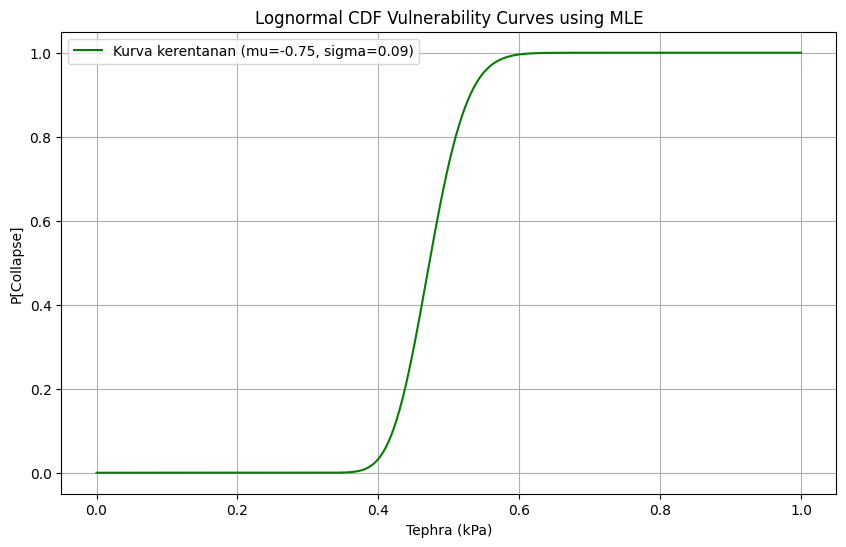

In [18]:
# Plotting
plt.figure(figsize=(10, 6))
prop = plot_fragility_curve(IM_DS1, damaged_roof, total_roof, 'Kurva kerentanan', 'Green')
plt.title('Lognormal CDF Vulnerability Curves using MLE')
plt.xlabel('Tephra (kPa)')
plt.ylabel('P[Collapse]')
plt.legend()
plt.grid(True)
plt.show()